In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import cifar10_input

from discretization_utils import one_hot_to_thermometer
from discretization_utils import discretize_uniform
from discretization_attacks import adv_lspga

from cifar_model import Model
import cifar10_input
levels = 16

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Attack:
    def __init__(self, model, num_steps, step_size, epsilon):
        self.model = model
        self.num_steps = num_steps
        self.step_size = step_size

        self.xs = tf.Variable(np.zeros((1, 32, 32, 3), dtype=np.float32),
                                    name='modifier')
        self.orig_xs = tf.placeholder(tf.float32, [None, 32, 32, 3])

        self.ys = tf.placeholder(tf.int32, [None])

        self.epsilon = epsilon

        delta = tf.clip_by_value(self.xs, 0, 255) - self.orig_xs
        delta = tf.clip_by_value(delta, -self.epsilon, self.epsilon)

        self.do_clip_xs = tf.assign(self.xs, self.orig_xs+delta)

        compare = tf.constant((256.0/levels)*np.arange(-1,levels-1).reshape((1,1,1,1,levels)),
                              dtype=tf.float32)
        inner = tf.reshape(self.xs,(-1, 32, 32, 3, 1)) - compare
        inner = tf.maximum(tf.minimum(inner/(256.0/levels), 1.0), 0.0)

        self.therm = tf.reshape(inner, (-1, 32, 32, levels*3))

        self.logits = logits = model(self.therm)

        self.uniform = discretize_uniform(self.xs/255.0, levels=levels, thermometer=True)
        self.real_logits = model(self.uniform)

        label_mask = tf.one_hot(self.ys, 10)
        correct_logit = tf.reduce_sum(label_mask * logits, axis=1)
        wrong_logit = tf.reduce_max((1-label_mask) * logits - 1e4*label_mask, axis=1)

        self.loss = (correct_logit - wrong_logit)

        start_vars = set(x.name for x in tf.global_variables())
        optimizer = tf.train.AdamOptimizer(step_size*1)
        self.grad = tf.sign(tf.gradients(self.loss, self.xs)[0])

        grad,var = optimizer.compute_gradients(self.loss, [self.xs])[0]
        self.train = optimizer.apply_gradients([(tf.sign(grad),var)])

        end_vars = tf.global_variables()
        self.new_vars = [x for x in end_vars if x.name not in start_vars]

    def perturb(self, x, y, sess):
        sess.run(tf.variables_initializer(self.new_vars))
        sess.run(self.xs.initializer)
        sess.run(self.do_clip_xs,
                 {self.orig_xs: x})

        for i in range(self.num_steps):

            t = sess.run(self.uniform)
            sess.run(self.train, feed_dict={self.ys: y,
                                            self.therm: t})
            sess.run(self.do_clip_xs,
                     {self.orig_xs: x})

        return sess.run(self.xs)

In [3]:
sess = tf.Session()
cifar = cifar10_input.CIFAR10Data()
model = Model('../models/thermometer_advtrain/',
              sess, tiny=False, mode='eval',
              thermometer=True, levels=levels)
attack = Attack(model,
                30,
                1,
                8)

Called
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Restoring parameters from ../models/thermometer_advtrain/checkpoint-68000
restored


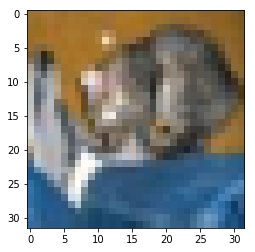

Image Label [3]
Clean Model Prediction [3]
Logits [[-1.3182435  2.5834875 -5.5870852 10.171819  -5.0424666  6.116695
  -4.9661837 -3.076646  -1.206701   2.325575 ]]


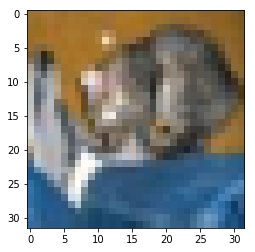

Max distortion 0.031372577
Adversarial Model Prediction [5]
Logits [[-0.8225111   0.85914516 -4.7383585   1.4677212  -2.8243408  11.350895
  -2.3103023  -3.077036   -1.6778117   1.7728287 ]]


In [4]:
xs = tf.placeholder(tf.float32, (1, 32, 32, 3))
encode = discretize_uniform(xs/255.0, levels=levels, thermometer=True)

image = np.array(cifar.eval_data.xs[:1],dtype=np.float32)
label = cifar.eval_data.ys[:1]

plt.imshow(image[0]/255.0)
plt.show()
print("Image Label", label)

thermometer_encoded = sess.run(encode, {xs: image})
print('Clean Model Prediction',
      sess.run(model.predictions, {model.x_input: thermometer_encoded}))
print('Logits',
      sess.run(model.pre_softmax, {model.x_input: thermometer_encoded}))

adversarial = attack.perturb(image, label, sess)

plt.imshow(image[0]/255.0)
plt.show()

print("Max distortion", np.max(np.abs(adversarial/255.0-image/255.0)))

thermometer_encoded = sess.run(encode, {xs: adversarial})
print('Adversarial Model Prediction',
      sess.run(model.predictions, {model.x_input: thermometer_encoded}))
print('Logits',
      sess.run(model.pre_softmax, {model.x_input: thermometer_encoded}))